In [55]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import time

In [132]:
num_nodes = 10
max_x = 100
max_y = 100

G = nx.Graph()

nodes_list = {}
for i in range(num_nodes):
    G.add_node(i)
    nodes_list[i] = {
        'position': (random.uniform(0, max_x), random.uniform(0, max_y)),  # random (x, y) position
        'bandwidth': random.randint(1, 10),
        'mobility': random.random(),  # random value between 0 and 1
        'transmission_power': random.uniform(5, 20),  # random value between 5 and 20
        'packet_loss': random.uniform(0, 1),  # random value between 0 and 1
        'battery_capacity': random.uniform(10, 100),  # random value between 10 and 100
    }

for i in range(num_nodes):
    for j in range(i+1, num_nodes):
        if np.random.rand() < 0.5:
            G.add_edge(i, j)

In [133]:
import pandas as pd

# Create a DataFrame from the nodes_list dictionary
nodes_df = pd.DataFrame(nodes_list).T

# Reset the index and rename the index column to 'Node'
nodes_df.reset_index(inplace=True)
nodes_df.rename(columns={'index': 'Node'}, inplace=True)

# Display the DataFrame
nodes_df


,Node,position,bandwidth,mobility,transmission_power,packet_loss,battery_capacity
0,0,"(83.3463175241535, 82.54903037979803)",6,0.295826,7.63852,0.327316,96.639047
1,1,"(60.27845656822605, 68.52656212067107)",6,0.492464,13.303819,0.415882,81.324213
2,2,"(72.59799745611654, 46.9521936951092)",10,0.330581,11.13784,0.123849,46.918086
3,3,"(93.40142871783499, 17.684515958270886)",9,0.514682,19.105753,0.718497,30.592133
4,4,"(54.16042114061958, 33.8128384274272)",9,0.416901,5.704678,0.779398,79.831022
5,5,"(48.56578529919378, 83.40283141869949)",4,0.403246,16.435855,0.748265,82.378116
6,6,"(78.85374354692584, 47.57158143214423)",7,0.142668,11.121896,0.997609,27.923804
7,7,"(88.9583752233367, 24.30448784349486)",2,0.174995,9.042149,0.827516,20.163469
8,8,"(41.21270608270224, 6.321354288860137)",3,0.965177,6.70145,0.872613,74.087758
9,9,"(85.65230030852243, 4.895480167526689)",9,0.333349,12.496076,0.940675,64.107915


In [134]:
def bellman_ford_modified_bandwidth_low_mobility_transmission_power_battery_capacity_low_packet_loss(source, destination, G, nodes_list):
    if source == destination:
        return [source]

    # Step 1: Initialize distances and predecessor nodes
    dist = {node: float('inf') for node in nodes_list.keys()}
    dist[source] = 0
    prev = {node: None for node in nodes_list.keys()}

    # Step 2: Relax edges repeatedly
    for i in range(len(nodes_list) - 1):
        for u, v in G.edges():
            bandwidth = min(nodes_list[u]['bandwidth'], nodes_list[v]['bandwidth'])
            mobility = max(nodes_list[u]['mobility'], nodes_list[v]['mobility'])
            transmission_power = min(nodes_list[u]['transmission_power'], nodes_list[v]['transmission_power'])
            battery_capacity = min(nodes_list[u]['battery_capacity'], nodes_list[v]['battery_capacity'])
            packet_loss = max(nodes_list[u]['packet_loss'], nodes_list[v]['packet_loss'])

            if dist[u] + (bandwidth - mobility + transmission_power + battery_capacity - packet_loss) < dist[v]:
                dist[v] = dist[u] + (bandwidth - mobility + transmission_power + battery_capacity - packet_loss)
                prev[v] = u

    # Step 3: Check for negative-weight cycles
    for u, v in G.edges():
        bandwidth = min(nodes_list[u]['bandwidth'], nodes_list[v]['bandwidth'])
        mobility = max(nodes_list[u]['mobility'], nodes_list[v]['mobility'])
        transmission_power = min(nodes_list[u]['transmission_power'], nodes_list[v]['transmission_power'])
        battery_capacity = min(nodes_list[u]['battery_capacity'], nodes_list[v]['battery_capacity'])
        packet_loss = max(nodes_list[u]['packet_loss'], nodes_list[v]['packet_loss'])

        if dist[u] + (bandwidth - mobility + transmission_power + battery_capacity - packet_loss) < dist[v]:
            raise ValueError("Negative weight cycle detected")

    # Step 4: Construct the shortest path from source to destination
    path = [destination]
    node = destination
    while prev[node] is not None:
        path.insert(0, prev[node])
        node = prev[node]

    return path


In [135]:
source = 2
destination = 9
path = bellman_ford_modified_bandwidth_low_mobility_transmission_power_battery_capacity_low_packet_loss(source, destination, G, nodes_list)
print(f"Path: {path}")

Path: [2, 8, 9]


In [136]:
def draw_network_graph(G, path, nodes_list):
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=False)
    
    # Draw the path taken by the routing function
    path_edges = [(path[i], path[i+1]) for i in range(len(path) - 1)]
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='r', width=2)
    
    # Draw node labels with their bandwidth and mobility
    labels = {i: f"{i}\nBW: {nodes_list[i]['bandwidth']} Mbps\nMobility: {nodes_list[i]['mobility']:.2f}" for i in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels)
    
    # Show the network graph with the path, bandwidth, and mobility
    plt.show()


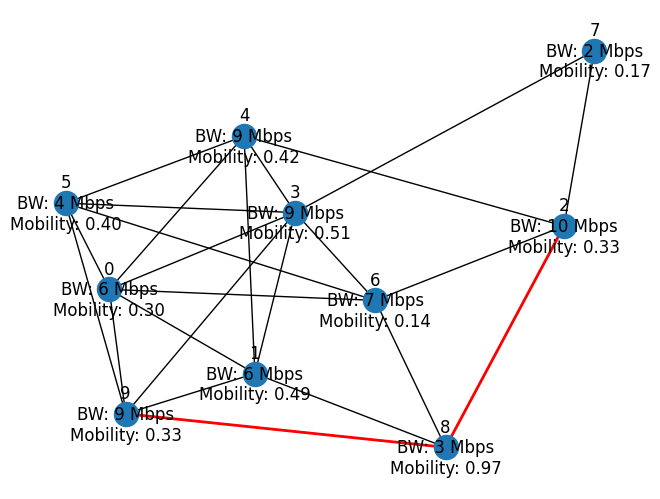

In [137]:
draw_network_graph(G, path, nodes_list)

In [138]:
import pandas as pd

def calculate_avg_health(G, path, nodes_list):
    data_list = []
    total_health = 0
    num_edges = 0
    bandwidth = 0
    mobility = 0
    transmission_power = 0
    battery_capacity = 0
    packet_loss = 0
    health = 0
    for i in range(len(path) - 1):
        node_a, node_b = path[i], path[i + 1]

        if G.has_edge(node_a, node_b):
            bandwidth = min(nodes_list[node_a]['bandwidth'], nodes_list[node_b]['bandwidth'])
            mobility = max(nodes_list[node_a]['mobility'], nodes_list[node_b]['mobility'])
            transmission_power = min(nodes_list[node_a]['transmission_power'], nodes_list[node_b]['transmission_power'])
            battery_capacity = min(nodes_list[node_a]['battery_capacity'], nodes_list[node_b]['battery_capacity'])
            packet_loss = max(nodes_list[node_a]['packet_loss'], nodes_list[node_b]['packet_loss'])

            health = bandwidth - mobility + transmission_power + battery_capacity - packet_loss
            total_health += health
            num_edges += 1

   
                # Creating a dictionary of variables and values for the current node pair
        data = {
                    "node_a": node_a,
                    "node_b": node_b,
                    "bandwidth": bandwidth,
                    "mobility": mobility,
                    "transmission_power": transmission_power,
                    "battery_capacity": battery_capacity,
                    "packet_loss": packet_loss,
                    "health": health
                }

                # Adding the dictionary to the list
        data_list.append(data)
    average_health = total_health / num_edges if num_edges > 0 else 0
    print("avg health of transfer "+str(average_health))
    # Converting the list of dictionaries into a DataFrame
    df1 = pd.DataFrame(data_list)
    df1.insert(loc=0, column='index', value='Bellman Ford')
    return df1


In [139]:
df1 = calculate_avg_health(G, path, nodes_list)
df1

avg health of transfer 63.342629339763164


,index,node_a,node_b,bandwidth,mobility,transmission_power,battery_capacity,packet_loss,health
0,Bellman Ford,2,8,3,0.965177,6.70145,46.918086,0.872613,54.781746
1,Bellman Ford,8,9,3,0.965177,6.70145,64.107915,0.940675,71.903513


In [101]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import time

In [184]:
num_nodes = 10
max_x = 100
max_y = 100

G = nx.Graph()

nodes_list = {}
for i in range(num_nodes):
    G.add_node(i)
    nodes_list[i] = {
        'position': (random.uniform(0, max_x), random.uniform(0, max_y)),  # random (x, y) position
        'bandwidth': random.randint(1, 10),
        'mobility': random.random(),  # random value between 0 and 1
        'transmission_power': random.uniform(5, 20),  # random value between 5 and 20
        'packet_loss': random.uniform(0, 1),  # random value between 0 and 1
        'battery_capacity': random.uniform(10, 100),  # random value between 10 and 100
    }

for i in range(num_nodes):
    for j in range(i+1, num_nodes):
        if np.random.rand() < 0.5:
            G.add_edge(i, j)

In [185]:
import pandas as pd

# Create a DataFrame from the nodes_list dictionary
nodes_df = pd.DataFrame(nodes_list).T

# Reset the index and rename the index column to 'Node'
nodes_df.reset_index(inplace=True)
nodes_df.rename(columns={'index': 'Node'}, inplace=True)

# Display the DataFrame
nodes_df


,Node,position,bandwidth,mobility,transmission_power,packet_loss,battery_capacity
0,0,"(45.84886171759959, 16.904721209914452)",10,0.543342,15.753745,0.560828,64.42782
1,1,"(25.450030637698006, 81.3977579955961)",9,0.768059,10.389683,0.623015,37.114817
2,2,"(64.35396672099452, 98.82455553093249)",4,0.697463,12.794317,0.02462,60.095534
3,3,"(80.04335794128731, 96.20145808621258)",5,0.965351,17.423841,0.712841,30.56032
4,4,"(31.861450806207348, 7.824239362159535)",6,0.790493,11.147143,0.240464,35.682683
5,5,"(89.63415797041276, 70.43044829658463)",8,0.500454,12.677927,0.951624,98.327354
6,6,"(15.239137482786457, 65.85034918889741)",2,0.078529,7.338761,0.699111,16.009147
7,7,"(19.034806935355007, 53.02820807828158)",1,0.111104,10.067664,0.86567,77.093898
8,8,"(49.073900511611136, 88.60415600856841)",9,0.32231,16.108019,0.500723,24.458142
9,9,"(31.844258487191222, 16.432871890882993)",7,0.348144,15.221624,0.916683,31.108177


In [186]:
def dijkstra_modified_bandwidth_low_mobility_transmission_power_battery_capacity_low_packet_loss(source, destination, G, nodes_list):
    if source == destination:
        return [source]

    visited = set()
    queue = [(source, [source])]

    shortest_path = None
    best_score = float('-inf')

    while queue:
        current, path = queue.pop(0)
        visited.add(current)

        for neighbor in G.neighbors(current):
            if neighbor not in visited:
                score = nodes_list[neighbor]['bandwidth'] - nodes_list[neighbor]['mobility'] + nodes_list[neighbor]['transmission_power'] + nodes_list[neighbor]['battery_capacity'] -  nodes_list[neighbor]['packet_loss']
                if score > best_score:
                    best_score = score
                    next_hop = neighbor
                if neighbor == destination:
                    shortest_path = path + [neighbor]
                    return shortest_path
        if best_score > float('-inf'):
            visited.add(next_hop)
            queue.append((next_hop, path + [next_hop]))
            best_score = float('-inf')

    return shortest_path


In [187]:
source = 2
destination = 9
path = dijkstra_modified_bandwidth_low_mobility_transmission_power_battery_capacity_low_packet_loss(source, destination, G, nodes_list)
print(f"Path: {path}")

Path: [2, 5, 0, 9]


In [188]:
def draw_network_graph(G, path, nodes_list):
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=False)
    
    # Draw the path taken by the routing function
    path_edges = [(path[i], path[i+1]) for i in range(len(path) - 1)]
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='r', width=2)
    
    # Draw node labels with their bandwidth and mobility
    labels = {i: f"{i}\nBW: {nodes_list[i]['bandwidth']} Mbps\nMobility: {nodes_list[i]['mobility']:.2f}" for i in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels)
    
    # Show the network graph with the path, bandwidth, and mobility
    plt.show()


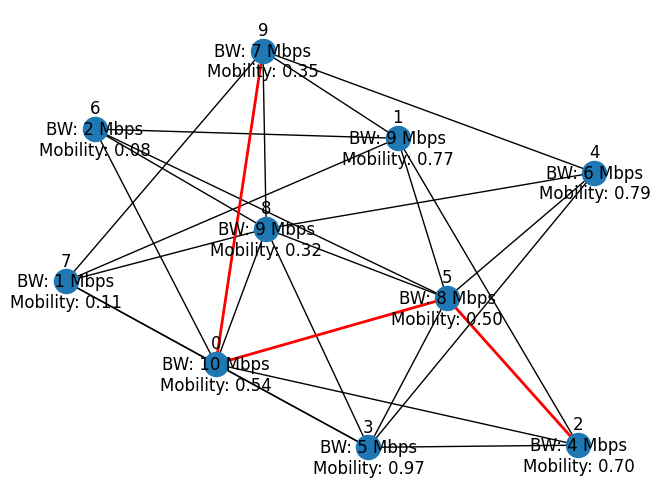

In [189]:
df2 = draw_network_graph(G, path, nodes_list)
df2 

In [190]:
import pandas as pd

def calculate_avg_health(G, path, nodes_list):
    data_list = []
    total_health = 0
    num_edges = 0
    bandwidth = 0
    mobility = 0
    transmission_power = 0
    battery_capacity = 0
    packet_loss = 0
    health = 0
    for i in range(len(path) - 1):
        node_a, node_b = path[i], path[i + 1]

        if G.has_edge(node_a, node_b):
            bandwidth = min(nodes_list[node_a]['bandwidth'], nodes_list[node_b]['bandwidth'])
            mobility = max(nodes_list[node_a]['mobility'], nodes_list[node_b]['mobility'])
            transmission_power = min(nodes_list[node_a]['transmission_power'], nodes_list[node_b]['transmission_power'])
            battery_capacity = min(nodes_list[node_a]['battery_capacity'], nodes_list[node_b]['battery_capacity'])
            packet_loss = max(nodes_list[node_a]['packet_loss'], nodes_list[node_b]['packet_loss'])

            health = bandwidth - mobility + transmission_power + battery_capacity - packet_loss
            total_health += health
            num_edges += 1

   
                # Creating a dictionary of variables and values for the current node pair
        data = {
                    "node_a": node_a,
                    "node_b": node_b,
                    "bandwidth": bandwidth,
                    "mobility": mobility,
                    "transmission_power": transmission_power,
                    "battery_capacity": battery_capacity,
                    "packet_loss": packet_loss,
                    "health": health
                }

                # Adding the dictionary to the list
        data_list.append(data)
    average_health = total_health / num_edges if num_edges > 0 else 0
    print("avg health of transfer "+str(average_health))
    # Converting the list of dictionaries into a DataFrame
    df2 = pd.DataFrame(data_list)
    df2.insert(loc=0, column='index', value='Dijkstra')
    return df2


In [191]:
df2 = calculate_avg_health(G, path, nodes_list)
df2 

avg health of transfer 70.20164413112997


,index,node_a,node_b,bandwidth,mobility,transmission_power,battery_capacity,packet_loss,health
0,Dijkstra,2,5,4,0.697463,12.677927,60.095534,0.951624,75.124375
1,Dijkstra,5,0,8,0.543342,12.677927,64.427820,0.951624,83.610781
2,Dijkstra,0,9,7,0.543342,15.221624,31.108177,0.916683,51.869776


In [165]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import time

In [166]:
num_nodes = 10
max_x = 100
max_y = 100

G = nx.Graph()

nodes_list = {}
for i in range(num_nodes):
    G.add_node(i)
    nodes_list[i] = {
        'position': (random.uniform(0, max_x), random.uniform(0, max_y)),  # random (x, y) position
        'bandwidth': random.randint(1, 10),
        'mobility': random.random(),  # random value between 0 and 1
        'transmission_power': random.uniform(5, 20),  # random value between 5 and 20
        'packet_loss': random.uniform(0, 1),  # random value between 0 and 1
        'battery_capacity': random.uniform(10, 100),  # random value between 10 and 100
    }

for i in range(num_nodes):
    for j in range(i+1, num_nodes):
        if np.random.rand() < 0.5:
            G.add_edge(i, j)

In [167]:
import pandas as pd

# Create a DataFrame from the nodes_list dictionary
nodes_df = pd.DataFrame(nodes_list).T

# Reset the index and rename the index column to 'Node'
nodes_df.reset_index(inplace=True)
nodes_df.rename(columns={'index': 'Node'}, inplace=True)

# Display the DataFrame
nodes_df


,Node,position,bandwidth,mobility,transmission_power,packet_loss,battery_capacity
0,0,"(46.820700206866285, 39.549717744105465)",6,0.573402,7.240089,0.275831,54.478023
1,1,"(76.77000870933387, 64.02391038536973)",6,0.42633,13.43357,0.567606,23.699156
2,2,"(21.524776162329285, 56.45171766168089)",9,0.436649,9.346447,0.634024,97.791645
3,3,"(99.42980164977006, 71.82764976279483)",4,0.88085,12.095305,0.601084,80.487406
4,4,"(60.34816434771897, 99.4089244381266)",9,0.801002,10.437188,0.176594,46.982053
5,5,"(84.3350710545473, 38.01551204696477)",6,0.124464,13.717986,0.037741,45.847935
6,6,"(53.8290981982791, 84.72578477437149)",2,0.597032,5.480009,0.513603,30.748149
7,7,"(57.82942729140627, 60.464716549731044)",3,0.675612,9.242017,0.166649,19.40295
8,8,"(88.91329940136721, 59.183848390006766)",10,0.580666,5.074604,0.587086,71.557779
9,9,"(34.313968733346854, 62.47523785656377)",4,0.708456,8.218303,0.125043,28.408741


In [168]:
import random
import numpy as np
import networkx as nx


def genetic_algorithm_dijkstra_shortest_path(source, destination, G, nodes_list):
    population_size = 50
    num_generations = 100
    mutation_probability = 0.1

    def generate_individual():
        return [random.randint(0, len(nodes_list)-1) for _ in range(random.randint(1, len(nodes_list)-1))]

    def calculate_fitness(individual):
        fitness = 0
        for i in range(len(individual)-1):
            start_node = individual[i]
            end_node = individual[i+1]
            node_props = nodes_list[start_node]
            fitness += 1 / node_props['bandwidth'] - node_props['mobility'] + node_props['transmission_power'] + node_props['battery_capacity'] - node_props['packet_loss']  # Use bandwidth as fitness metric
            fitness += nx.shortest_path_length(G, start_node, end_node, weight='weight')
        node_props = nodes_list[individual[-1]]
        fitness += 1 / node_props['bandwidth'] - node_props['mobility'] + node_props['transmission_power'] + node_props['battery_capacity'] - node_props['packet_loss']
        return fitness

    def selection(population):
        fitnesses = [calculate_fitness(individual) for individual in population]
        total_fitness = sum(fitnesses)
        probabilities = [fitness / total_fitness for fitness in fitnesses]
        indices = np.random.choice(range(len(population)), size=len(population), p=probabilities)
        return [population[index] for index in indices]

    def crossover(parent1, parent2):
        if len(parent1) > 1 and len(parent2) > 1:
            crossover_point = random.randint(1, min(len(parent1), len(parent2))-1)
            child1 = parent1[:crossover_point] + parent2[crossover_point:]
            child2 = parent2[:crossover_point] + parent1[crossover_point:]
            return child1, child2
        else:
            return parent1, parent2


    def mutation(individual):
        if random.random() < mutation_probability:
            index1 = random.randint(0, len(individual)-1)
            index2 = random.randint(0, len(nodes_list)-1)
            individual[index1] = index2

    population = [generate_individual() for _ in range(population_size)]
    for generation in range(num_generations):
        population = selection(population)
        new_population = []
        while len(new_population) < population_size:
            parent1 = random.choice(population)
            parent2 = random.choice(population)
            child1, child2 = crossover(parent1, parent2)
            mutation(child1)
            mutation(child2)
            new_population.append(child1)
            if len(new_population) < population_size:
                new_population.append(child2)
        population = new_population

    best_individual = min(population, key=calculate_fitness)
    best_path = [source] + best_individual + [destination]
    return best_path


In [169]:
source = 2
destination = 9
path = genetic_algorithm_dijkstra_shortest_path(source, destination, G, nodes_list)
print(f"Path: {path}")

Path: [2, 1, 8, 1, 2, 3, 5, 2, 3, 5, 9]


In [170]:
def draw_network_graph(G, path, nodes_list):
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=False)
    
    # Draw the path taken by the routing function
    path_edges = [(path[i], path[i+1]) for i in range(len(path) - 1)]
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='r', width=2)
    
    # Draw node labels with their bandwidth and mobility
    labels = {i: f"{i}\nBW: {nodes_list[i]['bandwidth']} Mbps\nMobility: {nodes_list[i]['mobility']:.2f}" for i in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels)
    
    # Show the network graph with the path, bandwidth, and mobility
    plt.show()


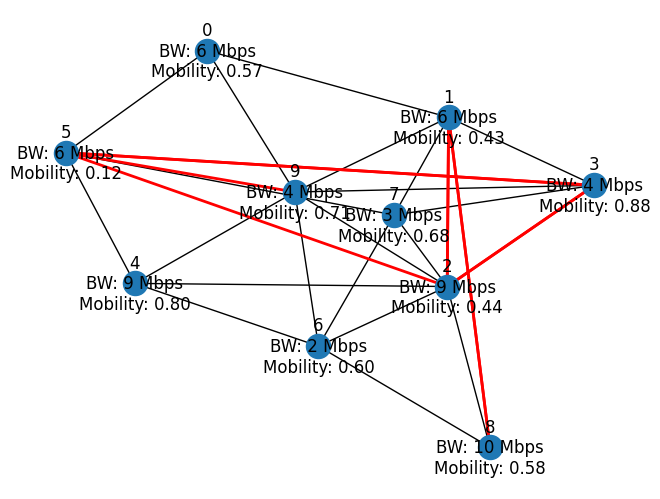

In [171]:
draw_network_graph(G, path, nodes_list)

In [172]:
import pandas as pd

def calculate_avg_health(G, path, nodes_list):
    data_list = []
    total_health = 0
    num_edges = 0

        # Initializing all variables to 0
    bandwidth = 0
    mobility = 0
    transmission_power = 0
    battery_capacity = 0
    packet_loss = 0
    health = 0
    
    for i in range(len(path) - 1):
        node_a, node_b = path[i], path[i + 1]

        if G.has_edge(node_a, node_b):
            bandwidth = min(nodes_list[node_a]['bandwidth'], nodes_list[node_b]['bandwidth'])
            mobility = max(nodes_list[node_a]['mobility'], nodes_list[node_b]['mobility'])
            transmission_power = min(nodes_list[node_a]['transmission_power'], nodes_list[node_b]['transmission_power'])
            battery_capacity = min(nodes_list[node_a]['battery_capacity'], nodes_list[node_b]['battery_capacity'])
            packet_loss = max(nodes_list[node_a]['packet_loss'], nodes_list[node_b]['packet_loss'])

            health = bandwidth - mobility + transmission_power + battery_capacity - packet_loss
            total_health += health
            num_edges += 1

   
                # Creating a dictionary of variables and values for the current node pair
        data = {
                    "node_a": node_a,
                    "node_b": node_b,
                    "bandwidth": bandwidth,
                    "mobility": mobility,
                    "transmission_power": transmission_power,
                    "battery_capacity": battery_capacity,
                    "packet_loss": packet_loss,
                    "health": health
                }

                # Adding the dictionary to the list
        data_list.append(data)
    average_health = total_health / num_edges if num_edges > 0 else 0
    print("avg health of transfer "+str(average_health))
    # Converting the list of dictionaries into a DataFrame
    df3 = pd.DataFrame(data_list)
    df3.insert(loc=0, column='index', value='Genetic')
    return df3


In [173]:
df3 = calculate_avg_health(G, path, nodes_list)
df3 

avg health of transfer 65.14695429961766


,index,node_a,node_b,bandwidth,mobility,transmission_power,battery_capacity,packet_loss,health
0,Genetic,2,1,6,0.436649,9.346447,23.699156,0.634024,37.974930
1,Genetic,1,8,6,0.436649,9.346447,23.699156,0.634024,37.974930
2,Genetic,8,1,6,0.436649,9.346447,23.699156,0.634024,37.974930
3,Genetic,1,2,6,0.436649,9.346447,23.699156,0.634024,37.974930
4,Genetic,2,3,4,0.880850,9.346447,80.487406,0.634024,92.318979
5,Genetic,3,5,4,0.880850,9.346447,80.487406,0.634024,92.318979
6,Genetic,5,2,4,0.880850,9.346447,80.487406,0.634024,92.318979
7,Genetic,2,3,4,0.880850,9.346447,80.487406,0.634024,92.318979
8,Genetic,3,5,4,0.880850,9.346447,80.487406,0.634024,92.318979
9,Genetic,5,9,4,0.880850,9.346447,80.487406,0.634024,92.318979


In [192]:
final_df = pd.concat([df1, df2, df3], ignore_index=True)
final_df

,index,node_a,node_b,bandwidth,mobility,transmission_power,battery_capacity,packet_loss,health
0,Bellman Ford,2,8,3,0.965177,6.701450,46.918086,0.872613,54.781746
1,Bellman Ford,8,9,3,0.965177,6.701450,64.107915,0.940675,71.903513
2,Dijkstra,2,5,4,0.697463,12.677927,60.095534,0.951624,75.124375
3,Dijkstra,5,0,8,0.543342,12.677927,64.427820,0.951624,83.610781
4,Dijkstra,0,9,7,0.543342,15.221624,31.108177,0.916683,51.869776
5,Genetic,2,1,6,0.436649,9.346447,23.699156,0.634024,37.974930
6,Genetic,1,8,6,0.436649,9.346447,23.699156,0.634024,37.974930
7,Genetic,8,1,6,0.436649,9.346447,23.699156,0.634024,37.974930
8,Genetic,1,2,6,0.436649,9.346447,23.699156,0.634024,37.974930
9,Genetic,2,3,4,0.880850,9.346447,80.487406,0.634024,92.318979
